# Applied Data Science Capstone - Weeks 4 & 5 Capstone Project

## Introduction

Singapore is an island nation located in Southeast Asia. For over two decades, Singapore has been a thriving global hub and one of the most successful financial hubs of Asia. It is a multicultural nation with a population of over 5 million people and a Gross Domestic Product (GDP) of over 360 billion USD.

As Singapore faces land scarcity and with the increasing numbers of businesses, economic competitiveness grows among businesses in Singapore. For this project, we are going to focus on finding the best possible location for our main office, with efforts in avoiding competition with other businesses in the same sector.

Suppose we want to start a travel agency business in Singapore. Travel agencies are less common nowadays, but is still a profitable business as starting one is usually inexpensive and there is still demand for tours, travel packages, customised trips, and so on. We would want to locate our main office in a strategic location so that people could drop by our office easily.

In order to avoid competition in this tight sector, we would want to avoid areas with many travel agencies and also not to locate our office closely to existing travel agencies. Moreover, we would want to locate our office as close as possible to means of transportation, venues, or landmarks of a targeted area.

The project objective is to advise those who want to start a travel agency business in Singapore, on where to best locate their main office depending on factors such as competition and accessibility. Other factors such as land pricing and area popularity are not accounted for in this project and will serve as future improvements.

## Data

<dd>For this project, we require the following data:</dd>
<ul>
  <li>List of regions and areas of Singapore.</li>
    <ul>
        <li>Source: <a href = "https://data.gov.sg/dataset/master-plan-2019-planning-area-boundary-no-sea">Data.gov.sg</a></li>
        <li>Description: This dataset contains area boundary data.</li>
        <li>Usage: This dataset contains complete area boundary data; however, we are only interested in the list of regions and areas of Singapore. We will extract this information from the above dataset.</li>
    </ul>
  <li>Geographical coordinates of each area.</li>
    <ul>
        <li>Source: Google Maps Platform – <a href = "https://developers.google.com/maps/documentation/geocoding/start">Geocoding API</a></li>
        <li>Description: This API facilitates the conversion between addresses and geographical coordinates.</li>
        <li>Usage: We will be using this API to generate geographical coordinates for a given area. The output coordinates will mostly be near any means of transportation or landmarks of a certain area. This API is preferred over OpenStreetMap Nominatim as it outputs more accurate results.</li>
    </ul>
  <li>List of existing travel agencies in each area.</li>
    <ul>
        <li>Source: <a href = "https://developer.foursquare.com/">Foursquare API</a></li>
        <li>Description: This API allows us to interact with Foursquare.</li>
        <li>Usage: We will be using this API to retrieve lists of existing travel agencies in each area. Moreover, we can retrieve details of each travel agency in a particular area.</li>
    </ul>

## Methodology

### Overview

<dd>Here's an overview of what we're going to do:</dd>
<ul>
    <li>Retrieve areas (neighbourhoods) and regions (boroughs) of Singapore using the area boundary data.</li>
    <li>Retrieve coordinates of all areas using the Google Maps Platform - Geocoding API (via GeoPy).</li>
    <li>Exploring travel agencies in all areas using Foursquare API.</li>
    <li>Select a possible region to locate our business.</li>
    <li>Retrieve venues near every area of that region using Foursquare API.</li>
    <li>Analyse the recommended venues and decide the best possible location in that region.</li>
    <li>Further calculate distances from MRT stations of areas with existing travel agencies to existing travel agencies in that area, and then decide the best possible location for our business in that area.</li>
</ul>

### Prerequisites

In this section, let us define the prerequisites for this project. This includes importing necessary libraries and initializing our API credentials (for Foursquare API and Google Geocoding API).

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import folium
import matplotlib
import matplotlib.pyplot as plt
from geopy.geocoders import GoogleV3
from geopy import distance
import json
from pandas.io.json import json_normalize

In [2]:
os.environ['FOURSQUARE_CLIENT_ID'] = 'YOUR_FOURSQUARE_CLIENT_ID'
os.environ['FOURSQUARE_CLIENT_SECRET'] = 'YOUR_FOURSQUARE_CLIENT_SECRET'

In [3]:
os.environ["GOOGLEGEO_APIKEY"] = 'YOUR_GOOGLEGEO_APIKEY'

### Part 1 - Identifying regions and areas of Singapore.

In this section, let us first explore Singapore and identify all the regions (boroughs) and areas (neighbourhoods). We will be using the area boundary data provided by Singapore's open data portal (Data.gov.sg) and the Google Geocoding API (via GeoPy). 

Let us open the area boundary data (one original for data, one modified for choropleth map).

In [4]:
with open('master-plan-2019-planning-area-boundary-no-sea-geojson.geojson') as a:
    geojson = json.load(a)
with open('modified-master-plan-2019-planning-area-boundary-no-sea-geojson.geojson') as b:
    mod_geojson = json.load(b)

We will now define a function called `SG_coordinates()` that returns latitude and longitude values for a specified input location within Singapore, using Google Geocoding API (via GeoPy).

In [5]:
def SG_coordinates(location):
    address = str(location) + ', Singapore'
    geolocator = GoogleV3(api_key = os.environ["GOOGLEGEO_APIKEY"])
    location = geolocator.geocode(address, timeout = 20)
    if location:
        return location.latitude, location.longitude
    else:
        return 0, 0

Next, we will generate a dataframe called `sg_data` that contains area, region, latitude, and longitude values.

In [6]:
area, region, latitude, longitude = [], [], [], []

for feature in geojson['features']:
    table = feature['properties']['Description']
    table = pd.DataFrame(pd.read_html(table)[0])
    area.append(table.iloc[0, 1])
    region.append(table.iloc[3, 1])
    lat, long = SG_coordinates(table.iloc[0, 1] + 'Neighborhood')
    latitude.append(lat)
    longitude.append(long)
    
sg_data = pd.DataFrame({'Area': area, 'Region': region, 'Latitude': latitude, 'Longitude': longitude})

After generating the dataframe, let us take a look on our dataframe and make sure it is relevant. Before doing so, we will define a function called `DF_shape()` that returns the number of rows and columns of a dataframe. We define a function so that we can easily call the function and print the shape of a dataframe.

In [7]:
def DF_shape(df):
    return "There are " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns in this dataframe."

In [8]:
print(DF_shape(sg_data))
sg_data.head()

There are 55 rows and 4 columns in this dataframe.


,Area,Region,Latitude,Longitude
0,BEDOK,EAST REGION,1.323604,103.927340
1,BOON LAY,WEST REGION,1.314256,103.709310
2,BUKIT BATOK,WEST REGION,1.349238,103.758483
3,BUKIT MERAH,CENTRAL REGION,1.281905,103.823918
4,BUKIT PANJANG,WEST REGION,1.386664,103.771581


Since we have only looked at the first five rows of the dataframe, we will now check if any of the values inside the dataframe equals zero, and then count the occurrences. Previously, I have tried using OpenStreetMap Nominatim (via GeoPy) and noticed that for some areas, it fails to return the coordinate values. This is why I have used Google Geocoding API (via GeoPy) in this project, as it returns more accurate results.

In [9]:
sg_data[sg_data.values == 0].count()

Area         0
Region       0
Latitude     0
Longitude    0
dtype: int64

Great! There are no missing values in our dataframe.

Let us now proceed to plot the number of areas by region.

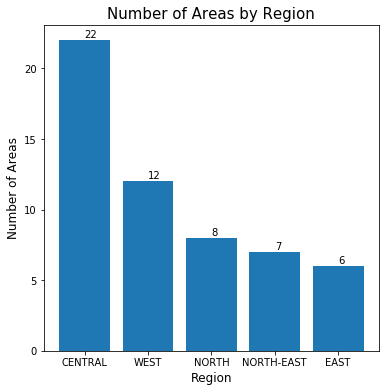

In [10]:
plt.figure(figsize = (6, 6))
region_list = []
for region in sg_data['Region'].value_counts().index.tolist():
    region_list.append(region.split()[0])
graph = plt.bar(region_list , sg_data['Region'].value_counts().tolist())
plt.title('Number of Areas by Region', fontsize = 15)
plt.xlabel('Region', fontsize = 12)
plt.ylabel('Number of Areas', fontsize = 12)
for bar in graph:
    plt.text(bar.get_xy()[0] + (bar.get_width() / 2), bar.get_height() + 0.2, bar.get_height())
plt.show()

From the graph above, we can tell that Singapore consists of 5 regions, namely Central Region, West Region, North Region, North-East Region and East Region. In total, there are 55 areas in Singapore.

In order to plot the map of Singapore, we require the geographical coordinates of Singapore. We will call the `SG_coordinates()` function to retrieve the latitude and longitude values, and then print the results we just got.

In [11]:
lat_value, long_value = SG_coordinates('')
print('The geograpical coordinates of Singapore are {}, {}.'.format(lat_value, long_value))

The geograpical coordinates of Singapore are 1.352083, 103.819836.


Let us plot and show the map of Singapore, indicating all the areas that we retrieved earlier.

In [12]:
sg_map = folium.Map(location = [lat_value, long_value], zoom_start = 12)

for lat, lng, region, area in zip(sg_data['Latitude'], sg_data['Longitude'], sg_data['Region'], sg_data['Area']):
    label = '{}, {}'.format(area, region)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(sg_map)
    
sg_map

### Part 2.1 - Exploring travel agencies in all areas of Singapore using Foursquare API.

In this section, we will explore travel agencies all across Singapore; in other words, we will explore travel agencies in all areas of Singapore, using the Foursquare API. 

Since we have initialized our Foursquare credentials earlier but not the Foursquare version parameter, let us first initialize the version parameter for the Foursquare API.

In [13]:
VERSION = '20200401'

We will now define a function called `getVenues()` that returns a list of venues in dataframe format for a given area dataframe (in our case it is going to be `sg_data`), Foursquare category ID (full list can be found <a href = "https://developer.foursquare.com/docs/build-with-foursquare/categories">here</a>), radius (in metres), and the limit for the number of results per a pair of latitude and longitude values (in other words, per area). Here, we use the `search` endpoint and not the `explore` endpoint as we want to retrieve a list of all travel agencies in each area.

In [14]:
def getVenues(data, category, radius, limit):
    venues_list = []
    for area, reg, lat, lng in zip(data['Area'], data['Region'], data['Latitude'], data['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
               os.environ['FOURSQUARE_CLIENT_ID'], os.environ['FOURSQUARE_CLIENT_SECRET'], VERSION, lat, lng, category,
               radius, limit)
        results = requests.get(url).json()["response"]['venues']
        venues_list.append([(area, reg, lat, lng, res['name'], res['location']['lat'], 
                             res['location']['lng'], res['categories'][0]['name'],
                             res['id']) for res in results])
    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Area', 'Region', 'Area Latitude', 'Area Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 
                      'Venue Category', 'Venue ID']
    return venues

We will set the category ID to travel agency (4f04b08c2fb6e1c99f3db0bd), the radius to 1500 metres and the limit to 50 results per area, as parameters for our `getVenues()` function.

In [15]:
CATEGORY_ID = '4f04b08c2fb6e1c99f3db0bd'
RADIUS = 1500
LIMIT = 50

Let us now search for travel agencies in each area using the function `getVenues()` that we defined earlier.

In [16]:
sg_ta = getVenues(sg_data, CATEGORY_ID, RADIUS, LIMIT)

Again, since we have generated a dataframe, let us take a look on our dataframe and make sure it is relevant.

In [17]:
print(DF_shape(sg_ta))
sg_ta.head()

There are 442 rows and 9 columns in this dataframe.


,Area,Region,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,BUKIT MERAH,CENTRAL REGION,1.281905,103.823918,Pricebreaker,1.293361,103.832605,Travel Agency,4dafa753a86e9639ef520ffe
1,BUKIT PANJANG,WEST REGION,1.386664,103.771581,WTS Travel,1.379745,103.764582,Travel Agency,4d6cc934fbf0a0933e88f68c
2,BUKIT PANJANG,WEST REGION,1.386664,103.771581,WTS Travel,1.377157,103.767049,Travel Agency,4d2d7249853ff04d1fdac8da
3,CHOA CHU KANG,WEST REGION,1.383980,103.746961,WTS Travel,1.384917,103.744998,Travel Agency,4bc18f614cdfc9b611dd9421
4,CHOA CHU KANG,WEST REGION,1.383980,103.746961,WTS Travel,1.376225,103.752877,Travel Agency,4d941dfd14a65481f14b0a4c


Since we have only looked at the first five rows of the dataframe, we will now check if any of the values inside the dataframe equals zero, and then count the occurrences.

In [18]:
sg_ta[sg_ta.values == 0].count()

Area               0
Region             0
Area Latitude      0
Area Longitude     0
Venue              0
Venue Latitude     0
Venue Longitude    0
Venue Category     0
Venue ID           0
dtype: int64

Great! There are no missing values in our dataframe, but there might be duplicated data. Let us now count the number of duplicated entries in the dataframe based on the unique Venue ID.

In [19]:
sg_ta[sg_ta.duplicated(['Venue ID'])].count()

Area               309
Region             309
Area Latitude      309
Area Longitude     309
Venue              309
Venue Latitude     309
Venue Longitude    309
Venue Category     309
Venue ID           309
dtype: int64

We found out that there are 309 duplicated entries in the dataframe. Duplicated entries have the same Venue ID, but different areas due to the areas being so close to each other. We will now proceed to drop duplicated entries based on their unique Venue ID, and only keeping the first duplicated entry.

In [20]:
sg_ta.drop_duplicates(subset = "Venue ID", keep = 'first', inplace = True)
sg_ta.reset_index(drop = True, inplace = True)

Let us take a look on our dataframe and make sure it is relevant.

In [21]:
print(DF_shape(sg_ta))
sg_ta.head()

There are 133 rows and 9 columns in this dataframe.


,Area,Region,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,BUKIT MERAH,CENTRAL REGION,1.281905,103.823918,Pricebreaker,1.293361,103.832605,Travel Agency,4dafa753a86e9639ef520ffe
1,BUKIT PANJANG,WEST REGION,1.386664,103.771581,WTS Travel,1.379745,103.764582,Travel Agency,4d6cc934fbf0a0933e88f68c
2,BUKIT PANJANG,WEST REGION,1.386664,103.771581,WTS Travel,1.377157,103.767049,Travel Agency,4d2d7249853ff04d1fdac8da
3,CHOA CHU KANG,WEST REGION,1.383980,103.746961,WTS Travel,1.384917,103.744998,Travel Agency,4bc18f614cdfc9b611dd9421
4,CHOA CHU KANG,WEST REGION,1.383980,103.746961,WTS Travel,1.376225,103.752877,Travel Agency,4d941dfd14a65481f14b0a4c


Let us now plot the number of travel agencies by area.

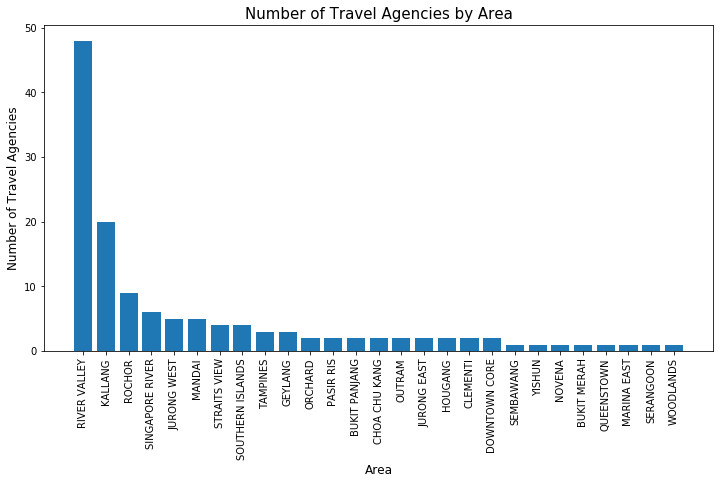

In [22]:
plt.figure(figsize = (12, 6))
graph = plt.bar(sg_ta['Area'].value_counts().index.tolist(), sg_ta['Area'].value_counts().tolist())
plt.title('Number of Travel Agencies by Area', fontsize = 15)
plt.xlabel('Area', fontsize = 12)
plt.ylabel('Number of Travel Agencies', fontsize = 12)
plt.yticks(np.arange(0, 51, step = 10))
plt.xticks(rotation = 90)
plt.show()

From the graph above, we can tell that the area River Valley has the most number of travel agencies. We can also tell that most areas have only less than 10 travel agencies. Notice that Singapore has 55 areas in total, but only 27 areas have travel agencies. Discovering this, we could actually locate our business in areas that does not have any existing travel agencies, but this is not a good way to conclude our analysis as most probably the market in those areas is not favourable for the travel agency business; so, we try to avoid those areas.

Let us plot a choropleth map indicating the number of travel agencies by area. First, we need to create a dataframe consisting of all areas and the number of travel agencies in respective areas. If an area does not have any travel agency, we assign NaN to that area. To show this, we print the top five and bottom five rows of the dataframe.

In [23]:
sg_cm = pd.DataFrame(sg_ta['Area'].value_counts().reset_index())
sg_cm.columns = ['Area', 'Number of Travel Agencies']
x = 0
for i in range(len(sg_data)):
    if sg_data['Area'][i] in sg_cm['Area'].tolist():
        pass
    else:
        sg_cm.loc[-1] = [sg_data['Area'][i], np.nan]
        sg_cm.index = sg_cm.index + 1 
sg_cm.reset_index(drop = True, inplace = True)
print(DF_shape(sg_cm))
pd.concat([sg_cm[:5], sg_cm[-5:]])

There are 55 rows and 2 columns in this dataframe.


,Area,Number of Travel Agencies
0,RIVER VALLEY,48.0
1,KALLANG,20.0
2,ROCHOR,9.0
3,SINGAPORE RIVER,6.0
4,JURONG WEST,5.0
50,TANGLIN,NaN
51,TENGAH,NaN
52,BISHAN,NaN
53,ANG MO KIO,NaN
54,PAYA LEBAR,NaN


Then, using the dataframe defined earlier, we will plot the choropleth map.

In [24]:
sg_cmap = folium.Map(location = [lat_value, long_value], zoom_start = 12)

sg_cmap.choropleth(
    geo_data = mod_geojson,
    data = sg_cm,
    columns = ['Area', 'Number of Travel Agencies'],
    key_on = 'feature.properties.name',
    fill_color = 'YlGnBu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Number of Travel Agencies',
    highlight = True
)

folium.LayerControl().add_to(sg_cmap)
sg_cmap

As shown in the choropleth map above, the more the number of travel agencies, the darker the color. Areas with the lightest green color does not have any travel agency. We can see that the majority of areas have either no or small number of travel agencies.

Let us now categorize those areas and proceed to plot the number of travel agencies by region.

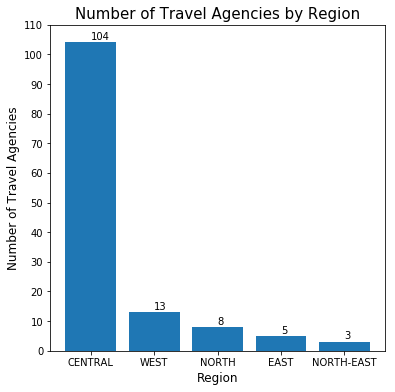

In [25]:
plt.figure(figsize = (6, 6))
region_list = []
for region in sg_ta['Region'].value_counts().index.tolist():
    region_list.append(region.split()[0])
graph = plt.bar(region_list, sg_ta['Region'].value_counts().tolist())
plt.title('Number of Travel Agencies by Region', fontsize = 15)
plt.xlabel('Region', fontsize = 12)
plt.ylabel('Number of Travel Agencies', fontsize = 12)
plt.yticks(np.arange(0, 111, step = 10))
for bar in graph:
    plt.text(bar.get_xy()[0] + (bar.get_width() / 2), bar.get_height() + 1, bar.get_height())
plt.show()

From the graph above, we can tell that there are 133 travel agencies in total. There are 104 travel agencies in the Central Region, which is the most in number compared to all other regions. We would want to avoid this region in order to satisfy one of our requirements, namely avoiding areas with many travel agencies. The other regions have moderate and low numbers of travel agencies. We will pick the region with moderate number of travel agencies, so in this case, we will pick West Region. Again, we avoid regions with low numbers of travel agencies as probably the market there is not favourable for our travel agency business.

### Part 2.2 - Exploring travel agencies in the West Region of Singapore using Foursquare API.

In this section, we will explore travel agencies in the West Region of Singapore using the Foursquare API.

Let us now gather more details and look into the travel agencies in the West Region, where we want to locate our travel agency business.

In [26]:
sg_west_ta = sg_ta[sg_ta['Region'] == 'WEST REGION'].reset_index(drop = True)
print(DF_shape(sg_west_ta))
sg_west_ta

There are 13 rows and 9 columns in this dataframe.


,Area,Region,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,BUKIT PANJANG,WEST REGION,1.386664,103.771581,WTS Travel,1.379745,103.764582,Travel Agency,4d6cc934fbf0a0933e88f68c
1,BUKIT PANJANG,WEST REGION,1.386664,103.771581,WTS Travel,1.377157,103.767049,Travel Agency,4d2d7249853ff04d1fdac8da
2,CHOA CHU KANG,WEST REGION,1.383980,103.746961,WTS Travel,1.384917,103.744998,Travel Agency,4bc18f614cdfc9b611dd9421
3,CHOA CHU KANG,WEST REGION,1.383980,103.746961,WTS Travel,1.376225,103.752877,Travel Agency,4d941dfd14a65481f14b0a4c
4,CLEMENTI,WEST REGION,1.316181,103.764938,Global Holidays,1.303585,103.764996,Travel Agency,4ffcde13e4b0279c5b32126a
5,CLEMENTI,WEST REGION,1.316181,103.764938,GEL Travel,1.303440,103.765246,Travel Agency,4e9247746da1ee43846b4960
6,JURONG EAST,WEST REGION,1.332857,103.743552,Causeway Link Counter,1.335069,103.746890,Travel Agency,572ddc1b498ed619e540c1c8
7,JURONG EAST,WEST REGION,1.332857,103.743552,Seiki Travel,1.336225,103.747141,Travel Agency,4e2273321495f18f03596d2b
8,JURONG WEST,WEST REGION,1.349435,103.714482,Five Stars Tours Boon Lay,1.347150,103.712392,Travel Agency,4d7a175470de54817ff1c499
9,JURONG WEST,WEST REGION,1.349435,103.714482,Grassland Express & Tours,1.347097,103.711845,Travel Agency,4dde281fd22d28453eb8aac9


Let us now categorize those travel agencies and proceed to plot the number of travel agencies by area of the West Region.

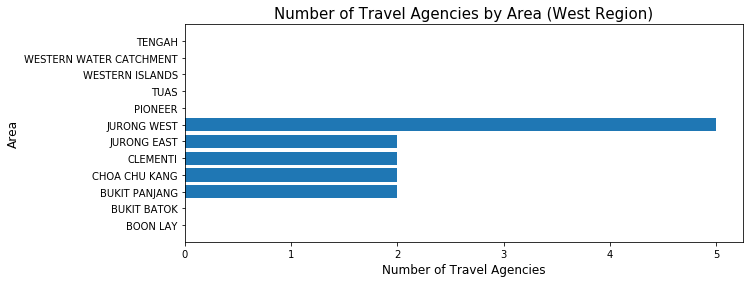

In [27]:
sg_west_areas = sg_data[sg_data['Region'] == 'WEST REGION']['Area'].reset_index(drop = True)
sg_west_count = []
for area in sg_west_areas:
    sg_west_count.append(len(sg_west_ta[sg_west_ta['Area'] == area]))
plt.figure(figsize = (10, 4))
graph = plt.barh(sg_west_areas, sg_west_count)
plt.title('Number of Travel Agencies by Area (West Region)', fontsize = 15)
plt.xlabel('Number of Travel Agencies', fontsize = 12)
plt.ylabel('Area', fontsize = 12)
plt.show()

Referring to the graph above, we can tell that in the areas Tengah, Western Water Catchment, Western Islands, Tuas, Pioneer, Bukit Batok and Boon Lay, travel agencies are not present. We could easily locate our travel agency in those areas, but first let us check the top five venues around those areas. Again, some areas might not be favourable for our business.

### Part 3 - Analysing the best possible location in the West Region.

In this section, we will analyse the best possible location in the West Region of Singapore using the Foursquare API.

Let's define a function called `getRecVenues()` that returns a list of recommended venues near an area.

In [28]:
def getRecVenues(data, radius, limit):
    venues_list = []
    for area, reg, lat, lng in zip(data['Area'], data['Region'], data['Latitude'], data['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
               os.environ['FOURSQUARE_CLIENT_ID'], os.environ['FOURSQUARE_CLIENT_SECRET'], VERSION, lat, lng, radius, limit)
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(area, reg, lat, lng, res['venue']['name'], res['venue']['location']['lat'], 
                             res['venue']['location']['lng'], res['venue']['categories'][0]['name'],
                             res['venue']['id']) for res in results])
    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Area', 'Region', 'Area Latitude', 'Area Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 
                      'Venue Category', 'Venue ID']
    return venues

Let us now search for the top five venues around the area using the function `getRecVenues()` that we defined earlier. We set the data parameter to `sg_west_data`, which consist of all areas in the West Region, the radius parameter to 250 metres, and the limit to 5 search results since we are looking only for the top five venues.

In [29]:
sg_west_data = sg_data[sg_data['Region'] == 'WEST REGION'].reset_index(drop = True)
sg_west_recven = getRecVenues(sg_west_data, 250, 5)

Let us count the values of each area, and display the name of areas based on set conditions.

In [30]:
sg_west_recven['Area'].value_counts()

BUKIT BATOK                5
CLEMENTI                   5
CHOA CHU KANG              5
BUKIT PANJANG              5
JURONG EAST                5
JURONG WEST                2
BOON LAY                   2
WESTERN WATER CATCHMENT    1
Name: Area, dtype: int64

In [31]:
five_recven = sg_west_recven['Area'].value_counts().loc[sg_west_recven['Area'].value_counts() == 5].index.tolist()
print("List of areas near 5 recommended venues:", five_recven)

List of areas near 5 recommended venues: ['BUKIT BATOK', 'CLEMENTI', 'CHOA CHU KANG', 'BUKIT PANJANG', 'JURONG EAST']


In [32]:
ltfive_recven = sg_west_recven['Area'].value_counts().loc[sg_west_recven['Area'].value_counts() != 5].index.tolist()
print("List of areas near < 5 recommended venues:", ltfive_recven)

List of areas near < 5 recommended venues: ['JURONG WEST', 'BOON LAY', 'WESTERN WATER CATCHMENT']


We notice that many areas do not have five recommended venues near the area. If an area is not listed above, it means there are zero recommended venues within 250m, so it's best if we avoid those areas as those areas might be remote areas/access may be limited and little venues surround those areas. Now, let us list down the top five recommended venues near the other areas.

In [33]:
pos = ['st', 'nd', 'rd']
columns = ['Area (WEST REGION)']
for i in np.arange(sg_west_recven['Area'].value_counts()[0]):
    try:
        columns.append('{}{} Recommended Venue'.format(i + 1, pos[i]))
    except:
        columns.append('{}th Recommended Venue'.format(i + 1))

sg_west_topven = pd.DataFrame(columns = columns)
for i in range(len(sg_west_recven['Area'].unique())):
    area = sg_west_recven['Area'].unique()[i]
    venue_list = [area]
    for venue in sg_west_recven[sg_west_recven['Area'] == area]['Venue Category']:
        venue_list.append(venue)
    if len(venue_list) != 6:
        for j in range(6 - len(venue_list)):
            venue_list.append('NONE')
    sg_west_topven.loc[i] = venue_list
sg_west_topven.style.applymap(lambda x: 'font-weight: bold' if x == 'NONE' else '')

,Area (WEST REGION),1st Recommended Venue,2nd Recommended Venue,3rd Recommended Venue,4th Recommended Venue,5th Recommended Venue
0,BOON LAY,Bus Station,Bus Station,NONE,NONE,NONE
1,BUKIT BATOK,Park,Food Court,Food Court,Fast Food Restaurant,Grocery Store
2,BUKIT PANJANG,Basketball Court,Athletics & Sports,Playground,Candy Store,Coffee Shop
3,CHOA CHU KANG,Portuguese Restaurant,Italian Restaurant,Supermarket,Pharmacy,Furniture / Home Store
4,CLEMENTI,Video Game Store,Soup Place,Dessert Shop,Bakery,Fried Chicken Joint
5,JURONG EAST,Clothing Store,Furniture / Home Store,Chinese Restaurant,Bakery,Movie Theater
6,JURONG WEST,Playground,Bus Stop,NONE,NONE,NONE
7,WESTERN WATER CATCHMENT,Fast Food Restaurant,NONE,NONE,NONE,NONE


First, let us construct another dataframe which consists of the area and the number of travel agencies in that area.

In [34]:
sg_west = pd.DataFrame(columns = ['Area (WEST REGION)', 'Number of Travel Agencies'])
for i in range(len(sg_west_count)):
    sg_west.loc[i] = [sg_west_areas.tolist()[i], sg_west_count[i]]
sg_west = sg_west[sg_west['Area (WEST REGION)'].isin(five_recven + ltfive_recven)].reset_index(drop = True)
sg_west

,Area (WEST REGION),Number of Travel Agencies
0,BOON LAY,0
1,BUKIT BATOK,0
2,BUKIT PANJANG,2
3,CHOA CHU KANG,2
4,CLEMENTI,2
5,JURONG EAST,2
6,JURONG WEST,5
7,WESTERN WATER CATCHMENT,0


Next, let us combine the above dataframe with the number of travel agencies in respective areas.

In [35]:
sg_west = pd.concat([sg_west, sg_west_topven], sort = False, axis = 1).sort_values('Number of Travel Agencies').reset_index(drop = True)
sg_west = sg_west.loc[:, ~sg_west.columns.duplicated()]
sg_west.style.applymap(lambda x: 'font-weight: bold' if x == 'NONE' else '')

,Area (WEST REGION),Number of Travel Agencies,1st Recommended Venue,2nd Recommended Venue,3rd Recommended Venue,4th Recommended Venue,5th Recommended Venue
0,BOON LAY,0,Bus Station,Bus Station,NONE,NONE,NONE
1,BUKIT BATOK,0,Park,Food Court,Food Court,Fast Food Restaurant,Grocery Store
2,WESTERN WATER CATCHMENT,0,Fast Food Restaurant,NONE,NONE,NONE,NONE
3,BUKIT PANJANG,2,Basketball Court,Athletics & Sports,Playground,Candy Store,Coffee Shop
4,CHOA CHU KANG,2,Portuguese Restaurant,Italian Restaurant,Supermarket,Pharmacy,Furniture / Home Store
5,CLEMENTI,2,Video Game Store,Soup Place,Dessert Shop,Bakery,Fried Chicken Joint
6,JURONG EAST,2,Clothing Store,Furniture / Home Store,Chinese Restaurant,Bakery,Movie Theater
7,JURONG WEST,5,Playground,Bus Stop,NONE,NONE,NONE


Referring to the above dataframe, we can decide where to locate our business based on two factors: the number of travel agencies in that particular area, and the venues near that area. We can locate our business in one of the following areas: Boon Lay, Bukit Batok, or Western Water Catchment as in those areas, there are no travel agencies present. Let us explore further.

We will now decide based on the nearby recommended venues. Based on the venues, we can tell that it is appropriate to locate our business in Bukit Batok as the nearby venues are mostly eateries, which is favourable for our business.

Alternatively, we can locate our business in Boon Lay as it is near two bus stations, but note that there are no other nearby interesting venues within 250m. We do not want to locate our business in Western Water Catchment as it is only near a fast food restaurant, and there is no other nearby interesting venues or means of transportation within 250m.

Lastly, let's say we want to locate our travel agency business in Bukit Panjang, Choa Chu Kang, Clementi, or Jurong East, where there are only two travel agencies in each area. We would want to maximize the distance between our travel agency and the existing travel agencies in order to avoid competition. Again, we avoid Jurong West in order to avoid competition with the existing five travel agencies and there are only two recommended venues within 250m.

Suppose we locate our business near the MRT (Mass Rapid Transit) station of each area. Let us explore the distances. 

First, let us define a function called `calcDistance()` that returns the geographical distance between two coordinate pairs.

In [36]:
def calcDistance(coord1, coord2):
    return distance.distance(coord1, coord2).km

Next, we define a function called `calcCoords()` that returns the geographical coordinate pair for each Venue Latitude and Venue Longitude for a given area in a dataframe.

In [37]:
def calcCoords(df, area):
    length = len(df[df['Area'] == area])
    coords = np.empty([length, 2], dtype = float)
    for i in range(length):
        coords[i] = np.array([df[df['Area'] == area]['Venue Latitude'].reset_index(drop = True).astype(float)[i],
                              df[df['Area'] == area]['Venue Longitude'].reset_index(drop = True).astype(float)[i]])
    return coords

Then, let us calculate the distance between Bukit Panjang MRT/LRT Station and the existing travel agencies there.

In [38]:
c1 = np.array([SG_coordinates('Bukit Panjang MRT/LRT Station')])
c2 = calcCoords(sg_west_ta, 'BUKIT PANJANG')
print("The distance between Bukit Panjang MRT/LRT Station and the 1st existing travel agency there is:", round(calcDistance(c1, c2[0]), 3), "km.")
print("The distance between Bukit Panjang MRT/LRT Station and the 2nd existing travel agency there is:", round(calcDistance(c1, c2[1]), 3), "km.")

The distance between Bukit Panjang MRT/LRT Station and the 1st existing travel agency there is: 0.284 km.
The distance between Bukit Panjang MRT/LRT Station and the 2nd existing travel agency there is: 0.527 km.


Next, let us calculate the distance between Choa Chu Kang MRT Station and the existing travel agencies there.

In [39]:
c1 = np.array([SG_coordinates('Choa Chu Kang MRT Station')])
c2 = calcCoords(sg_west_ta, 'CHOA CHU KANG')
print("The distance between Choa Chu Kang MRT Station and the 1st existing travel agency there is:", round(calcDistance(c1, c2[0]), 3), "km.")
print("The distance between Choa Chu Kang MRT Station and the 2nd existing travel agency there is:", round(calcDistance(c1, c2[1]), 3), "km.")

The distance between Choa Chu Kang MRT Station and the 1st existing travel agency there is: 0.088 km.
The distance between Choa Chu Kang MRT Station and the 2nd existing travel agency there is: 1.387 km.


Next, let us calculate the distance between Clementi MRT Station and the existing travel agencies there.

In [40]:
c1 = np.array([SG_coordinates('Clementi MRT Station')])
c2 = calcCoords(sg_west_ta, 'CLEMENTI')
print("The distance between Clementi MRT Station and the 1st existing travel agency there is:", round(calcDistance(c1, c2[0]), 3), "km.")
print("The distance between Clementi MRT Station and the 2nd existing travel agency there is:", round(calcDistance(c1, c2[1]), 3), "km.")

The distance between Clementi MRT Station and the 1st existing travel agency there is: 1.28 km.
The distance between Clementi MRT Station and the 2nd existing travel agency there is: 1.296 km.


Finally, let us calculate the distance between Jurong East MRT Station and the existing travel agencies there.

In [41]:
c1 = np.array([SG_coordinates('Jurong East MRT Station')])
c2 = calcCoords(sg_west_ta, 'JURONG EAST')
print("The distance between Jurong East MRT Station and the 1st existing travel agency there is:", round(calcDistance(c1, c2[0]), 3), "km.")
print("The distance between Jurong East MRT Station and the 2nd existing travel agency there is:", round(calcDistance(c1, c2[1]), 3), "km.")

The distance between Jurong East MRT Station and the 1st existing travel agency there is: 0.575 km.
The distance between Jurong East MRT Station and the 2nd existing travel agency there is: 0.658 km.


In this case, we prefer to locate our travel agency business near Clementi MRT Station, as the distances from Clementi MRT Station to existing travel agencies in Clementi are quite far away (>1 km); thus, satisfying our requirement of maximizing the distance between our travel agency and the existing travel agencies in order to avoid competition. Moreover, the recommended venues in Clementi comprise of mostly eateries, which is favorable for our business.

## Results

<dd>I have explained the results I got in the notebook cells above. Here's the summarized results:</dd>
<ul>
    <li>In Singapore, there are only 133 travel agencies in total and no travel agency is present in more than half of the areas. Specifically, travel agencies are only present in only 27 areas out of 55 areas.</li>
    <li>Most of the travel agencies are located in the Central Region and in total, there are 104 travel agencies located in the Central Region.</li>
    <li>Few travel agencies are located in the other regions, namely West, North, East, North-East regions. The number of travel agencies for each region are 13, 8, 5, and 3 respectively.</li>
    <li>Out of all areas with travel agencies, most areas have less than 10 travel agencies.</li>
    <li>In the West Region, 5 travel agencies are located in Jurong West, and the other areas have 2 or no travel agencies present.</li>
    <li>Only 5 out of 12 areas in the West Region have 5 recommended venues.</li>
    <li>Most of the surrounding recommended venues in the West Region are eateries and shops.</li>
    <li>In areas with 2 existing travel agencies in the West Region, the distances between the MRT station and the existing travel agencies is maximized in Clementi, and minimized in Bukit Panjang.</li>
</ul>

## Discussion

Based on the results obtained above, we can tell that there are few travel agencies in Singapore. We avoid the Central Region as it is packed with travel agencies, and chose the West Region as it has a moderate number of existing travel agencies. Other regions have small numbers of existing travel agencies, but while this may avoid competition, the market or demand there may be challenging or unsupportive for our business. Hence, we chose the West Region.

The West Region consists of 12 areas, and most areas have 2 or no travel agencies present. We decided to not easily choose the area with the least number of existing travel agencies, and explore the surrounding venues of each area. We then found out that only 5 out of 12 areas have 5 recommended venues, and most of the surrounding recommended venues are eateries and shops.

Based on the venues, we can tell that it is appropriate to locate our business in Bukit Batok as the nearby venues are mostly eateries and there are no existing travel agencies in this area, which is favourable for our business. Alternatively, we can locate our business in Boon Lay as it is near two bus stations, but note that there are no other nearby interesting venues within 250m.

Finally, we explored areas with 2 existing travel agencies in the West Region as the surrounding recommended venues are favorable for our business. We then found out that it is appropriate to locate our business in Clementi as the distances between the MRT Station and existing travel agencies are maximized, avoiding competition.

## Conclusion

The purpose of this project is to identify optimal areas with low numbers of existing travel agencies and also supportive surrounding venues. This is to avoid competition in this tight sector and enhance customer experience. By using Google Geocoding API to generate geographical coordinates and calculate distance based on geographical coordinates, and using Foursquare API to list down and explore venues based on the coordinates, we analyzed this data and derived the optimal areas to start our business, namely Bukit Batok and Clementi.

Although we only examined the West Region due to the moderate number of existing travel agencies, we can use the same analysis to examine other regions and derive optimal areas in other regions. This project does not pinpoint exact locations on where to start the business, but rather suggest optimal areas. This analysis is derived from the data provided by Foursquare, and the data accuracy and integrity solely depends on the source of data.

To conclude, the final decision on where to locate the business depends on several other factors such as land or rental prices, land availability, area popularity, demand in each area, and so on. Note that travel agencies are less common nowadays, but is still a potential business idea as the capital requirement to start a travel agency is generally low and can be very profitable, and also there is still demand for tours and travel packages.